In [6]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Pooled model this is chri and amos approach


In [7]:
path = r"/Users/christian/supsi/6th sem/bayesian_retry/retry/points_df.csv"
path2 = r"/Users/christian/supsi/6th sem/bayesian_retry/retry/outcomes.csv"
observed = pd.read_csv(path2, index_col=0)
points_df = pd.read_csv(path, index_col=0)
points_df

,EHC Biel-Bienne (away),HC Lugano (away),ZSC Lions (home),HC Ambri-Piotta (away),SC Bern (home),EV Zug (home),Genève-Servette HC (away),SC Rapperswil-Jona Lakers (home),SCL Tigers (away),HC Davos (home),...,ZSC Lions (away),HC Ambri-Piotta (home),SC Bern (away),EV Zug (away),Genève-Servette HC (home),EHC Biel-Bienne (home),SC Rapperswil-Jona Lakers (away),Lausanne HC (home),HC Ajoie (home),HC Ajoie (away)
HC Ajoie,3.500000,7.000000,6.500000,2.000000,4.000000,6.500000,3.500000,4.666667,1.500000,4.500000,...,3.333333,2.500000,4.000000,4.000000,3.500000,5.5,6.0,3.500000,0.000000,0.000000
SC Bern,3.666667,2.000000,2.000000,3.500000,0.000000,3.500000,2.333333,2.000000,1.000000,3.500000,...,1.000000,3.000000,0.000000,2.500000,2.500000,7.0,2.5,3.666667,1.500000,0.500000
Fribourg-Gottéron,2.000000,2.000000,4.500000,1.500000,1.500000,3.000000,1.333333,4.500000,2.000000,1.000000,...,2.250000,4.000000,2.333333,3.500000,2.500000,2.5,1.5,3.000000,0.500000,2.000000
ZSC Lions,2.500000,3.000000,0.000000,2.000000,4.000000,2.666667,3.500000,3.333333,2.666667,2.500000,...,0.000000,1.000000,2.000000,2.600000,3.000000,1.6,2.0,3.500000,2.666667,2.000000
Genève-Servette HC,1.333333,3.000000,5.500000,6.500000,2.333333,3.000000,0.000000,3.000000,1.500000,2.000000,...,0.500000,1.500000,1.000000,2.000000,0.000000,3.5,0.5,2.500000,3.500000,2.500000
EV Zug,2.500000,1.800000,1.000000,2.000000,3.500000,0.000000,4.500000,4.000000,2.000000,1.250000,...,2.166667,2.333333,1.500000,0.000000,3.500000,3.5,2.5,3.500000,1.500000,1.500000
HC Davos,1.000000,1.000000,3.666667,1.500000,3.000000,4.500000,1.000000,2.500000,4.000000,0.000000,...,3.000000,2.500000,2.000000,1.500000,3.000000,2.5,2.5,2.000000,2.000000,0.000000
HC Lugano,4.000000,0.000000,5.000000,1.333333,2.500000,4.800000,2.333333,1.500000,2.500000,3.000000,...,3.500000,2.000000,1.500000,4.400000,2.333333,4.0,1.5,6.000000,2.500000,1.000000
SC Rapperswil-Jona Lakers,3.500000,3.500000,4.000000,3.000000,3.000000,1.500000,1.500000,0.000000,3.000000,3.166667,...,3.333333,3.000000,2.000000,1.500000,3.000000,2.5,0.0,2.000000,2.500000,1.666667
Lausanne HC,2.000000,6.000000,3.000000,1.750000,2.000000,1.500000,1.000000,6.000000,3.000000,3.500000,...,2.500000,2.333333,1.666667,2.000000,3.000000,2.0,5.0,0.000000,1.500000,2.000000


In [13]:
# not sure about what to include in x and y...
filter_col = []
filter_col2 = []

for col in points_df.columns:
    if "home" in col:
        filter_col.append(col)
    else:
        filter_col2.append(col)
    
print(filter_col)
print(filter_col2)

x = points_df[filter_col].values
y = points_df[filter_col2].values.astype(np.float64).T

mu_y = y.mean()
s_y = y.std()
s_x = x.std()
x.shape,y.shape

#((13, 26), (3, 13))

['ZSC Lions (home)', 'SC Bern (home)', 'EV Zug (home)', 'SC Rapperswil-Jona Lakers (home)', 'HC Davos (home)', 'Fribourg-Gottéron (home)', 'SCL Tigers (home)', 'HC Lugano (home)', 'HC Ambri-Piotta (home)', 'Genève-Servette HC (home)', 'EHC Biel-Bienne (home)', 'Lausanne HC (home)', 'HC Ajoie (home)']
['EHC Biel-Bienne (away)', 'HC Lugano (away)', 'HC Ambri-Piotta (away)', 'Genève-Servette HC (away)', 'SCL Tigers (away)', 'HC Davos (away)', 'Fribourg-Gottéron (away)', 'Lausanne HC (away)', 'ZSC Lions (away)', 'SC Bern (away)', 'EV Zug (away)', 'SC Rapperswil-Jona Lakers (away)', 'HC Ajoie (away)']


((13, 13), (13, 13))

In [14]:
# model
with pm.Model() as pooled_model:
    # priors:
    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=13)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x, beta)

    y_pred = pm.StudentT ('y_pred', nu=3.6, mu=mu, sd=sigma, observed=y)

    # inference:
    trace_pooled = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


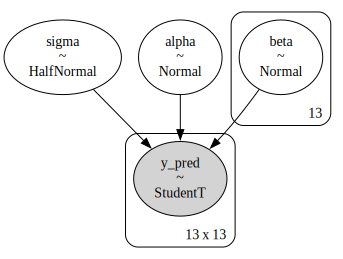

In [15]:
pm.model_to_graphviz(pooled_model)

## Checking convergence

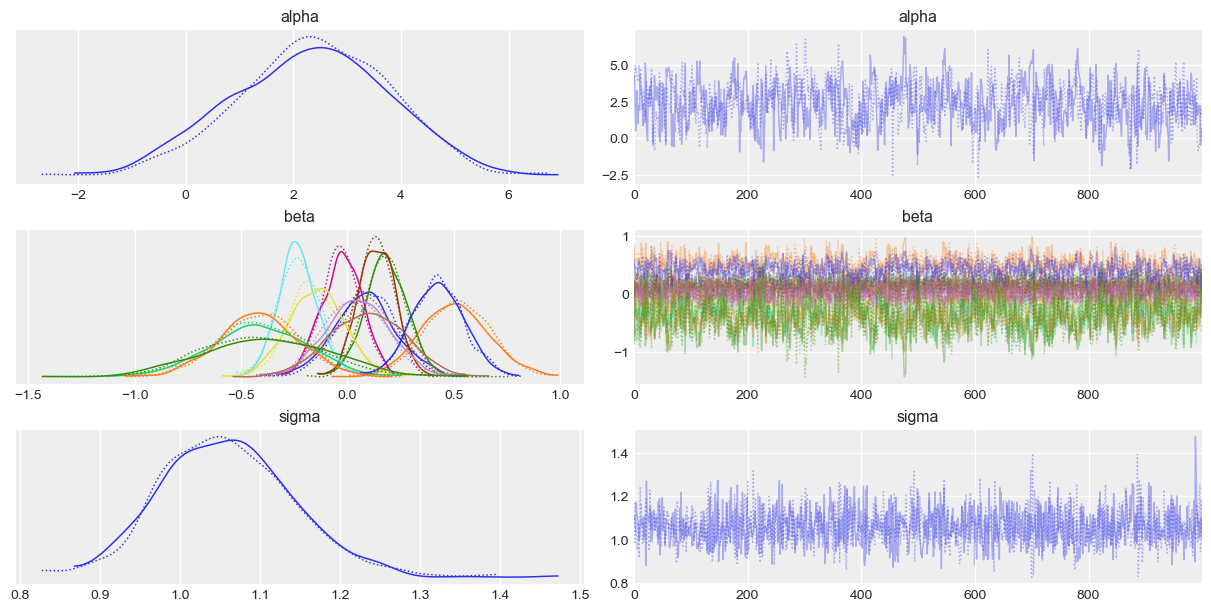

In [16]:
with pooled_model:
    az.plot_trace(trace_pooled)

In [17]:
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.348,1.455,-0.299,5.086,0.073,0.051,400.0,856.0,1.0
beta[0],0.087,0.140,-0.187,0.338,0.006,0.004,615.0,803.0,1.0
beta[1],0.511,0.156,0.195,0.782,0.006,0.004,709.0,1012.0,1.0
beta[2],0.179,0.098,-0.000,0.364,0.003,0.002,1093.0,1055.0,1.0
beta[3],-0.028,0.094,-0.194,0.156,0.003,0.002,1198.0,1408.0,1.0
beta[4],0.136,0.082,-0.019,0.281,0.002,0.002,1215.0,1156.0,1.0
beta[5],-0.232,0.095,-0.419,-0.058,0.003,0.002,920.0,1119.0,1.0
beta[6],-0.146,0.129,-0.377,0.101,0.006,0.004,445.0,903.0,1.0
beta[7],-0.418,0.218,-0.848,-0.031,0.009,0.007,532.0,921.0,1.0
beta[8],0.045,0.150,-0.225,0.329,0.007,0.005,503.0,1119.0,1.0


## Predictive checks

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


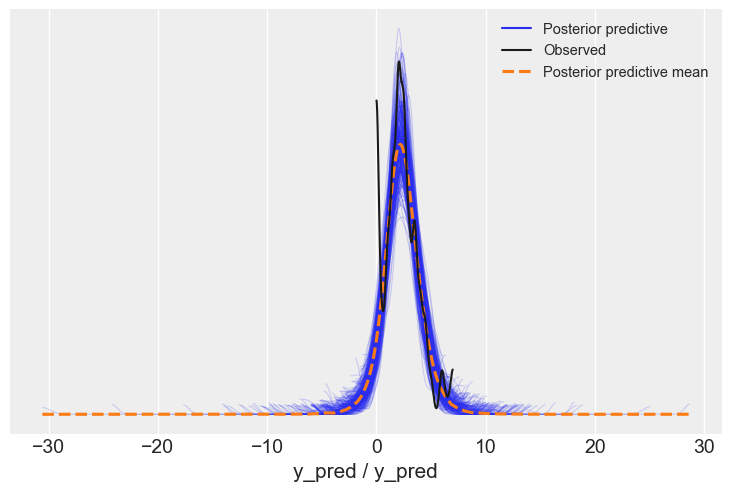

In [18]:
with pooled_model:
     ppc = pm.sample_posterior_predictive(trace_pooled, samples=300)
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pooled_model));

### mean HC Lugano

In [19]:
hcl_idx = points_df.index.to_list().index('HC Lugano')
# print(hcl_idx)
x_hcl = np.array(x)[hcl_idx, :]
x_hcl

array([5.        , 2.5       , 4.8       , 1.5       , 3.        ,
       3.        , 5.        , 0.        , 2.        , 2.33333333,
       4.        , 6.        , 2.5       ])

In [22]:
post_pool = az.extract_dataset(trace_pooled.posterior)
alpha_samples = post_pool.alpha.values.reshape(2000)
beta_samples = post_pool.beta.values.reshape(2000, 13)
mu_team = alpha_samples + np.dot(x_hcl, beta_samples.T)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_43636/3304957165.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_pool = az.extract_dataset(trace_pooled.posterior)


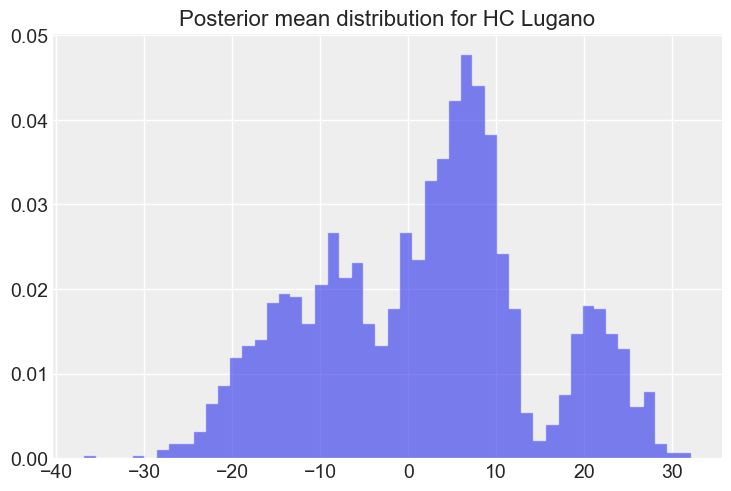

HC Lugano predicted mean: 1.833
HC Lugano predicted mean standard deviation: 12.564


In [23]:
# plot the posterior predictive distribution
plt.hist(mu_team, bins=50, density=True, histtype='stepfilled', alpha=0.6)
plt.title('Posterior mean distribution for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team.std():.3f}')

### prediction for next game

In [25]:
post_pool = az.extract_dataset(trace_pooled.posterior)

alpha_samples = post_pool.alpha.values.reshape(2000)
beta_samples = post_pool.beta.values.reshape(2000, 13)
sigma_samples = post_pool.sigma.values.reshape(2000)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_43636/3275563718.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_pool = az.extract_dataset(trace_pooled.posterior)


In [26]:
x_hcl_test = x[0].ravel()

predictive_distribution = []

for i in range(len(alpha_samples)):
    mu_team = alpha_samples[i] + np.dot(x_hcl_test, beta_samples[i])
    y_pred = np.random.normal(mu_team, sigma_samples[i])

    y_pred = np.random.normal(loc=mu_team, scale=sigma_samples[i])
    predictive_distribution.append(y_pred)

Text(0.5, 1.0, "Prediction for HC Lugano's points next game")

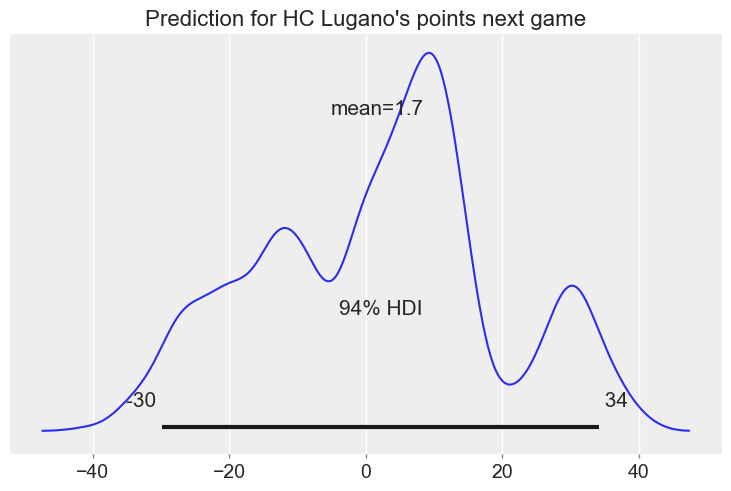

In [27]:
az.plot_posterior(np.array(predictive_distribution))
plt.title("Prediction for HC Lugano's points next game")

## Posterior novel prediction

In [28]:
# Save the team for novel predictions
novel_player_features = points_df.tail(1).iloc[:,3:13].values[0]

x_new = novel_player_features

In [21]:
with pm.Model() as model_pooled_with_prediction:

    alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
    beta = pm.Normal('beta', mu=0, sigma=s_x, shape=10)
    sigma = pm.HalfNormal('sigma', sigma=s_y)

    # likelihood:
    mu = alpha + pm.math.dot(x, beta)

    # observed data:
    y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, observed= y)

    # Novel player
    x_novel = pm.Data("x_novel", x_new)
    mu_novel = alpha + pm.math.dot(x_novel, beta)
    y_novel = pm.Normal("y_novel", mu=mu_novel, sigma=sigma)

In [22]:
with model_pooled_with_prediction:
    # inference:
    trace_novel = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_novel, sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.7034596375124125, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
with model_pooled_with_prediction:
    display(az.summary(trace_novel, var_names=['y_novel']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_novel,2.46,1.042,0.42,4.385,0.036,0.026,817.0,665.0,1.01


# Unpooled model

In [24]:
unpooled_models = []
unpooled_traces = []
for i in range(hcl_idx-5, hcl_idx):
    # sampling variables
    mu_y = y[i].mean()
    s_y = y[i].std()
    s_x = np.mean(np.std(x[i]))

    # model
    with pm.Model() as unpooled_model:
        # priors:
        alpha = pm.Normal('alpha', mu=mu_y, sigma=s_y)
        beta = pm.Normal('beta', mu=0, sigma=s_x, shape=10)
        sigma = pm.HalfNormal('sigma', sigma=s_y)

        # likelihood:
        mu = alpha + pm.math.dot(x[i], beta)

        # observed data:
        y_pred = pm.StudentT ('y_pred', nu=4, mu=mu, sd=sigma, 
                              observed= y[i])
        trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

    unpooled_models.append(unpooled_model)
    unpooled_traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


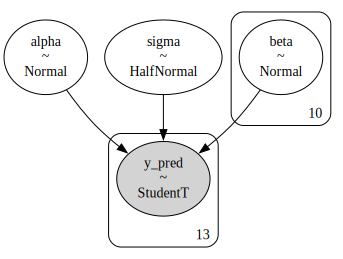

In [25]:
pm.model_to_graphviz(unpooled_models[-1])

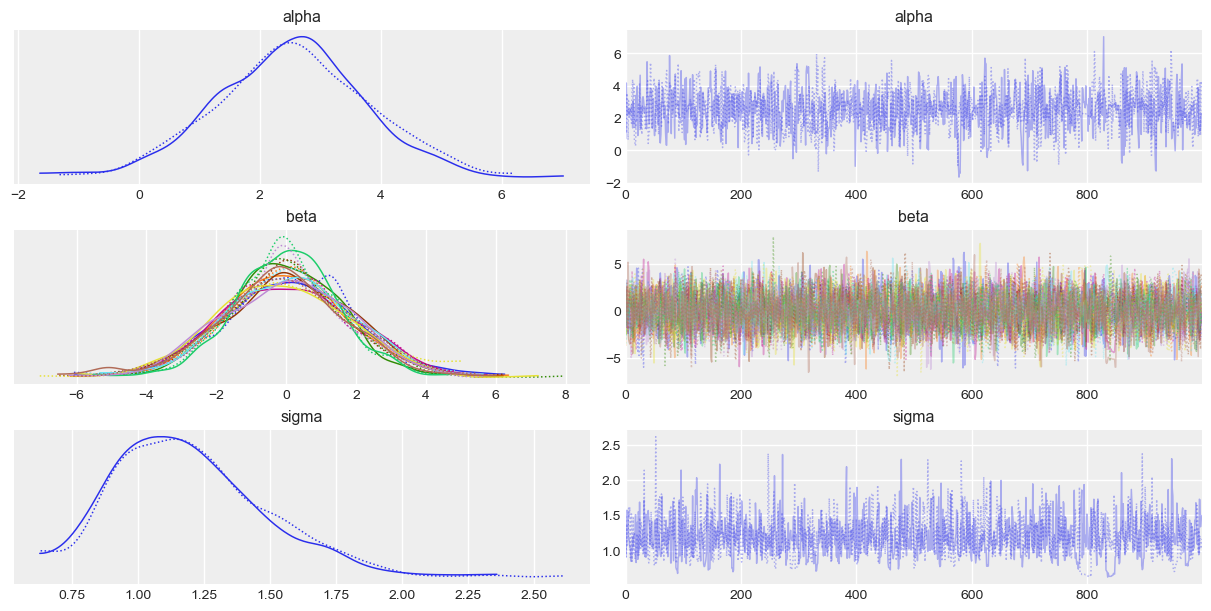

In [26]:
with unpooled_models[-1]:
    az.plot_trace(unpooled_traces[-1])

In [27]:
with unpooled_models[-1]:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.524,1.234,0.043,4.737,0.033,0.024,1373.0,945.0,1.00
beta[0],0.075,1.859,-3.327,3.415,0.048,0.047,1512.0,1243.0,1.00
beta[1],0.044,1.743,-3.268,3.263,0.052,0.044,1128.0,1032.0,1.01
beta[2],-0.062,1.658,-3.056,3.297,0.048,0.041,1202.0,1058.0,1.00
beta[3],0.056,1.847,-3.338,3.388,0.061,0.056,897.0,490.0,1.00
beta[4],0.031,1.817,-3.526,3.383,0.051,0.049,1275.0,1053.0,1.00
beta[5],0.078,1.785,-3.135,3.419,0.055,0.053,1064.0,634.0,1.00
beta[6],0.003,1.933,-3.542,3.824,0.067,0.061,809.0,420.0,1.00
beta[7],-0.018,1.467,-2.612,2.945,0.044,0.035,1112.0,1114.0,1.00
beta[8],-0.020,1.773,-3.478,3.159,0.047,0.048,1416.0,1298.0,1.00


## Posterior prediction of mean for HC Lugano

In [28]:
trace_hcl = unpooled_traces[-1]
model_hcl = unpooled_models[-1]

In [29]:
post_up = az.extract_dataset(trace_hcl.posterior)

alpha_samples = post_up.alpha.values.reshape(2000)
beta_samples = post_up.beta.values.reshape(2000, 10)
mu_team = alpha_samples + np.dot(x_hcl, beta_samples.T)

/var/folders/n3/51xp5_rs54v10cnshxhwyt480000gn/T/ipykernel_28730/1403213277.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  post_up = az.extract_dataset(trace_hcl.posterior)


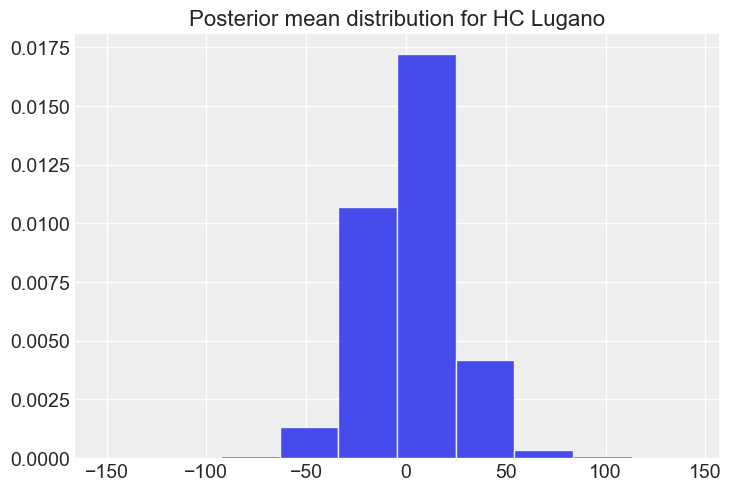

HC Lugano predicted mean: 2.811
HC Lugano predicted mean standard deviation: 22.553


In [30]:
# plot the posterior mean distribution
plt.hist(mu_team, bins=10, density=True, alpha=0.85)
plt.title('Posterior mean distribution for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team.std():.3f}')

## Posterior prediction

In [31]:
post_up = az.convert_to_dataset(trace_hcl)
mu_hcl_up = post_up.alpha[-1]
sigma_up = post_up.sigma.values[-1]

y_hcl_unpooled = np.zeros(len(mu_hcl_up))

for i, current_mu in enumerate(mu_hcl_up):
    y_hcl_unpooled[i] = np.random.normal(loc = mu_hcl_up[i], scale = sigma_up[i])

df = pd.DataFrame(y_hcl_unpooled)
df.describe(percentiles=[0.025, 0.975])

,0
count,1000.000000
mean,2.547213
std,1.664796
min,-3.398072
2.5%,-0.703603
50%,2.482362
97.5%,5.995144
max,8.332164


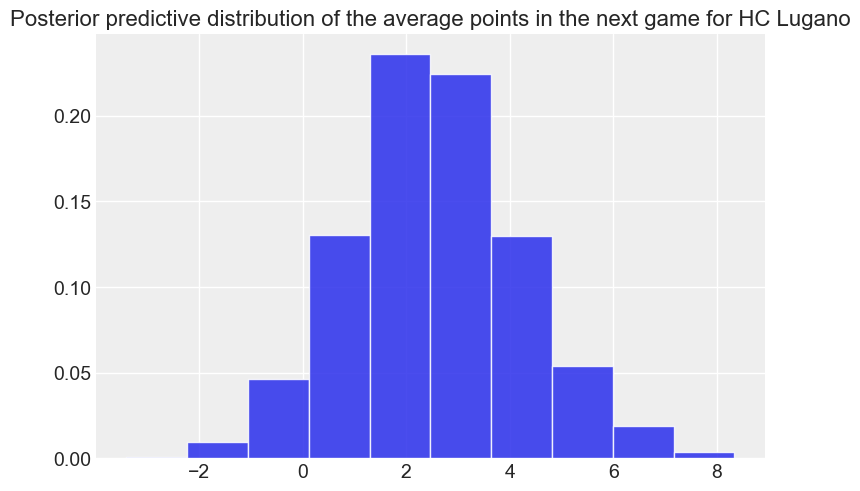

HC Lugano predicted points: 2.547
HC Lugano predicted points standard deviation: 1.664


In [32]:
# plot the posterior predictive distribution
plt.hist(y_hcl_unpooled, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted points: {y_hcl_unpooled.mean():.3f}')
print(f'HC Lugano predicted points standard deviation: {y_hcl_unpooled.std():.3f}')

# Hierarchical model

For this model we assume that all the teams have the same distribution for their coefficients, but also have some variation.

We define the model:
$y_{i,j}$: the team j's observed score for game i.

$\alpha_j$ : the intercept for team j.

$x_i$: the standardized points scored for game i.

$\beta_j$ : the regression coefficients for the j-th feature of the model for team j.

$\epsilon_i$ random variation of the measures.

In this model, we sample $\alpha_j$ and $\beta_j$ values for each team j from a common distribution, with hyper-priors:

$\mu_{\alpha} \sim Normal(\mu_{y}, \sigma_{y})$

$\sigma_{\alpha} \sim HalfNormal(6.8)$

$\mu_{\beta} \sim Normal(0,10)$

$\sigma_{\beta} \sim HalfNormal(10)$

$\sigma \sim HalfNormal(\sigma_{y})$

using 5 different teams.

In [33]:
hier_models = []
hier_traces = []
for i in range(hcl_idx-5, hcl_idx):

    # sampling variables
    mu_y = y[i].mean()
    s_y = y[i].std()
    s_x = np.mean(np.std(x[i]))

    with pm.Model() as hier_model:
        # hyper-priors
        mu_alpha = pm.Normal('mu_alpha', mu=mu_y, sigma=s_y)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
        mu_beta = pm.Normal('mu_beta', mu=0, sigma=10, shape=10)
        sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=s_y)

        # priors
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=10)

        # likelihood
        mu = alpha + pm.math.dot(x[i], beta)
        y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y[i])

        trace = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)
        hier_models.append(hier_model)
        hier_traces.append(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 49 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


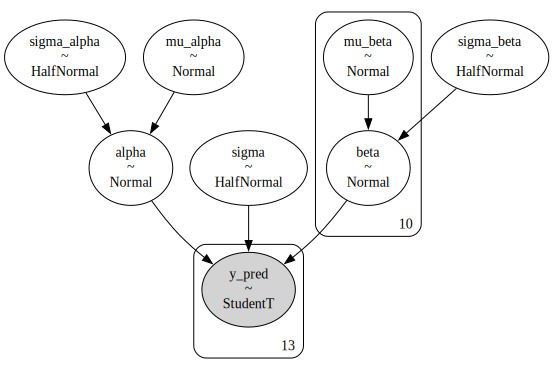

In [34]:
pm.model_to_graphviz(hier_models[-1])

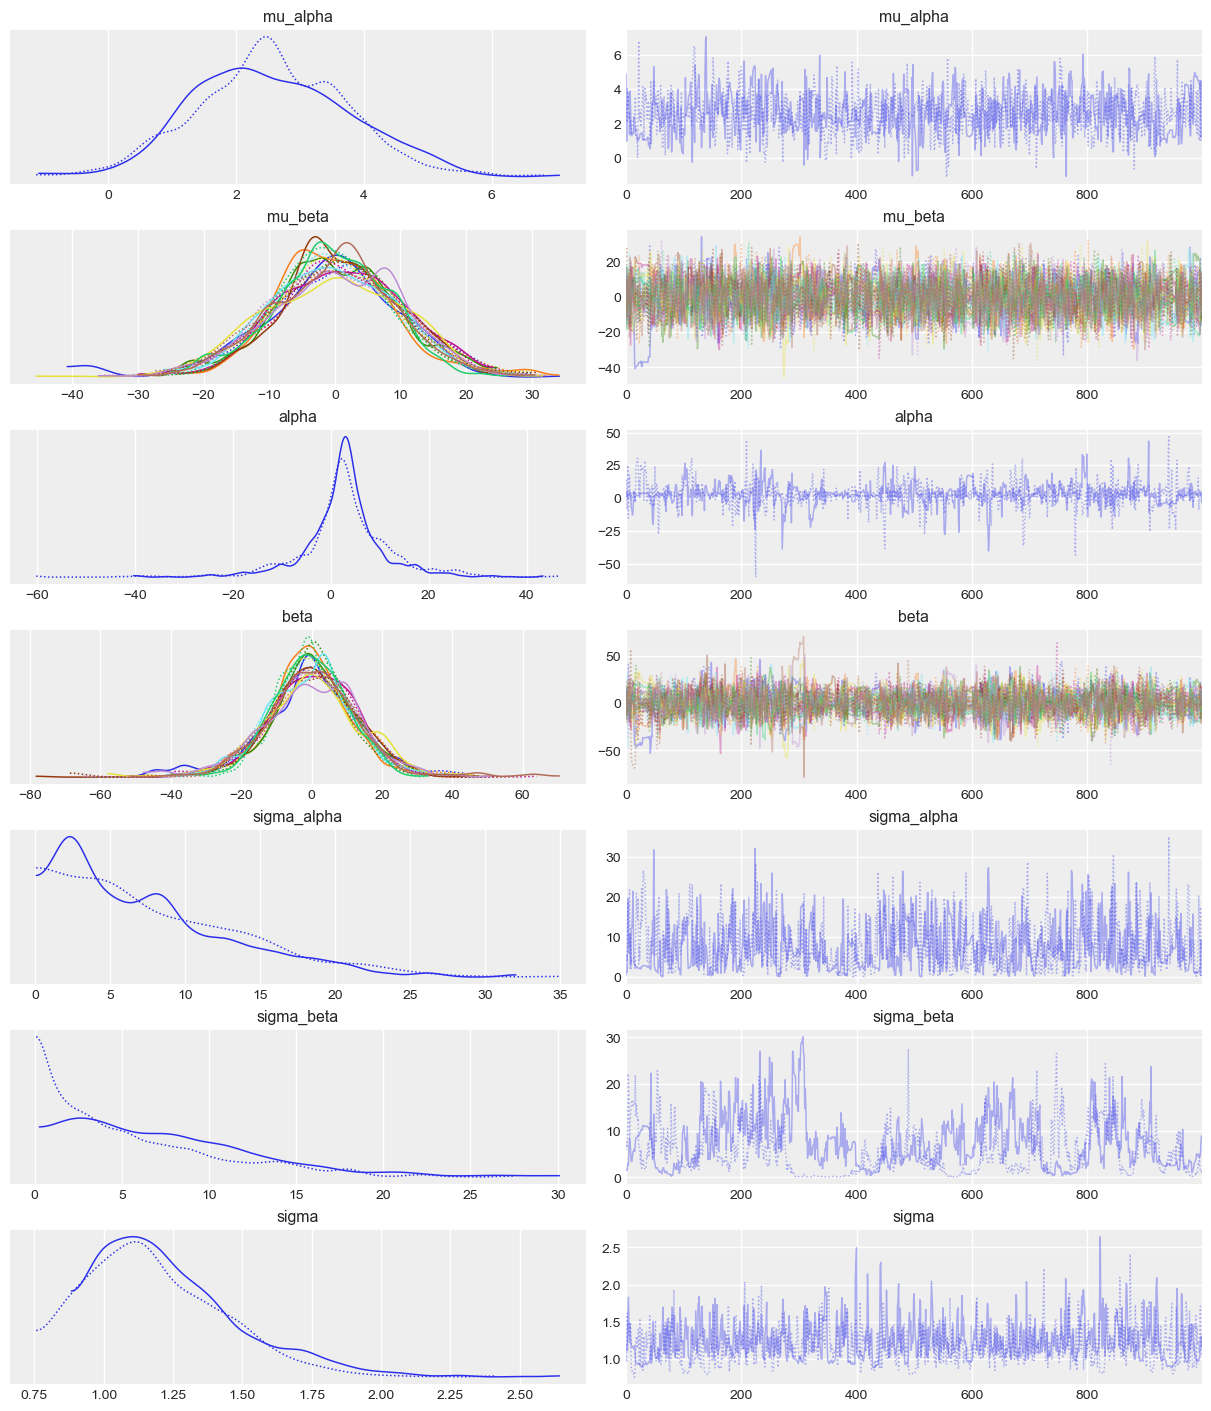

In [35]:
az.plot_trace(hier_traces[-1]);

In [36]:
with unpooled_models[-1]:
    display(az.summary(hier_traces[-1]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,2.559,1.209,0.306,4.786,0.045,0.032,711.0,800.0,1.00
mu_beta[0],-0.336,10.744,-20.520,19.000,0.673,0.711,346.0,201.0,1.01
mu_beta[1],0.493,9.872,-17.725,20.307,0.438,0.385,518.0,436.0,1.01
mu_beta[2],0.022,9.252,-17.589,17.788,0.465,0.329,398.0,459.0,1.00
mu_beta[3],0.738,9.668,-15.407,19.519,0.481,0.340,385.0,251.0,1.01
mu_beta[4],0.469,9.421,-16.373,18.716,0.348,0.282,726.0,831.0,1.01
mu_beta[5],-0.296,9.332,-16.791,16.669,0.372,0.309,630.0,683.0,1.00
mu_beta[6],-0.207,10.223,-18.718,18.250,0.454,0.337,505.0,737.0,1.00
mu_beta[7],-0.287,8.584,-16.568,15.997,0.394,0.300,479.0,422.0,1.00
mu_beta[8],0.025,9.920,-17.745,18.690,0.430,0.304,539.0,839.0,1.00


## Posterior mean

In [37]:
trace_hcl_hier = hier_traces[-1]
model_hcl_hier = hier_models[-1]

In [38]:
alpha_samples = trace_hcl_hier.posterior.alpha.values.reshape(2000)
beta_samples = trace_hcl_hier.posterior.beta.values.reshape(2000, 10)
mu_team_hier = alpha_samples + np.dot(x_hcl, beta_samples.T)

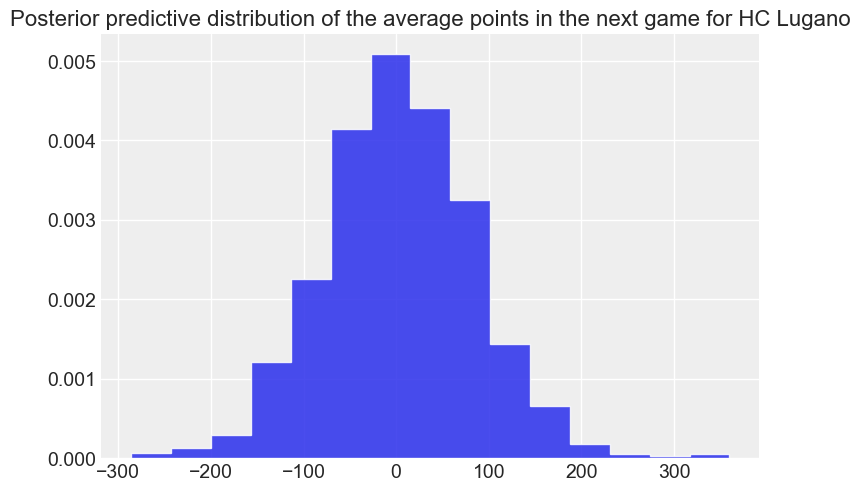

HC Lugano predicted mean: 3.906
HC Lugano predicted mean standard deviation: 80.924


In [39]:
# plot the posterior mean distribution
plt.hist(mu_team_hier, bins=15, density=True,histtype='stepfilled',  alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted mean: {mu_team_hier.mean():.3f}')
print(f'HC Lugano predicted mean standard deviation: {mu_team_hier.std():.3f}')

## Posterior prediction

In [40]:
post_hier = az.convert_to_dataset(trace_hcl_hier)
mu_hcl_hier = post_hier.alpha[-1]
sigma_hier = post_hier.sigma.values[-1]

y_hcl_hier = np.zeros(len(mu_hcl_hier))

for i, current_mu in enumerate(mu_hcl_hier):
    y_hcl_hier[i] = np.random.normal(loc = mu_hcl_hier[i], scale = sigma_hier[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
df = pd.DataFrame(y_hcl_hier)
df.describe(percentiles=[0.025, 0.975])

,0
count,1000.000000
mean,3.126036
std,9.708794
min,-58.845678
2.5%,-15.897207
50%,2.837538
97.5%,24.461185
max,47.118227


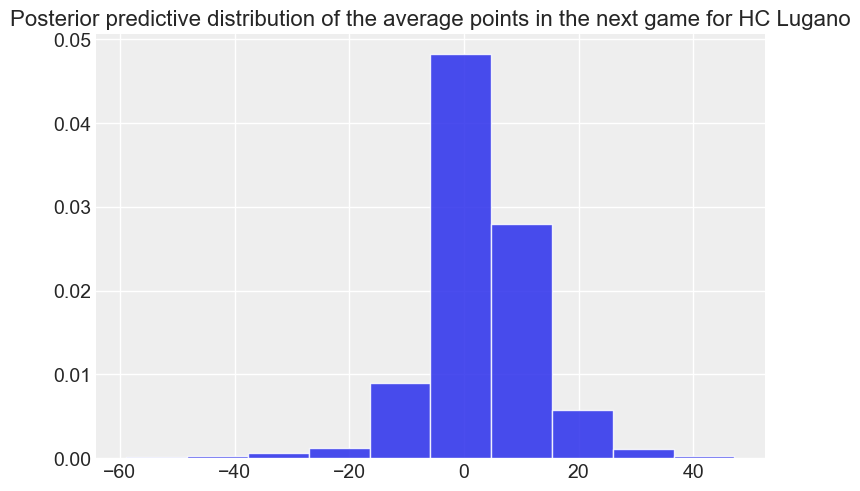

HC Lugano predicted points: 3.126
HC Lugano predicted points standard deviation: 9.704


In [41]:
# plot the posterior predictive distribution
plt.hist(y_hcl_hier, bins=10, density=True, alpha=0.85)
plt.title('Posterior predictive distribution of the average points in the next game for HC Lugano')
plt.show()

# print the mean and standard deviation of the posterior predictive distribution
print(f'HC Lugano predicted points: {y_hcl_hier.mean():.3f}')
print(f'HC Lugano predicted points standard deviation: {y_hcl_hier.std():.3f}')

## Novel prediction

In [42]:
x_new = novel_player_features
x_new = np.array(x_new, dtype=float)

In [43]:
novel_player_features

array([1. , 2. , 3.5, 1.5, 3.5, 3.5, 5.5, 2.5, 1.5, 1.5])

In [44]:
with pm.Model() as hier_n_pred:
    # hyper-priors

    mu_alpha = pm.Normal('mu_alpha', mu=3.6, sigma=1.8)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=10)
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=10, shape=10)
    sigma_beta = pm.HalfNormal('sigma_beta', sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=3)

    # priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=10)

    # likelihood
    mu = alpha + pm.math.dot(x, beta)
    y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y)

    # Novel player
    x_novel = pm.Data("x_novel", x_new)
    mu_novel = alpha + pm.math.dot(x_novel, beta)
    y_novel = pm.Normal("y_novel", mu=mu_novel, sigma=sigma)

    trace_h_novel = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_novel, beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [45]:
with hier_n_pred:
    display(az.summary(trace_h_novel, var_names=['y_novel']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_novel,2.471,1.037,0.481,4.367,0.028,0.023,1430.0,926.0,1.0


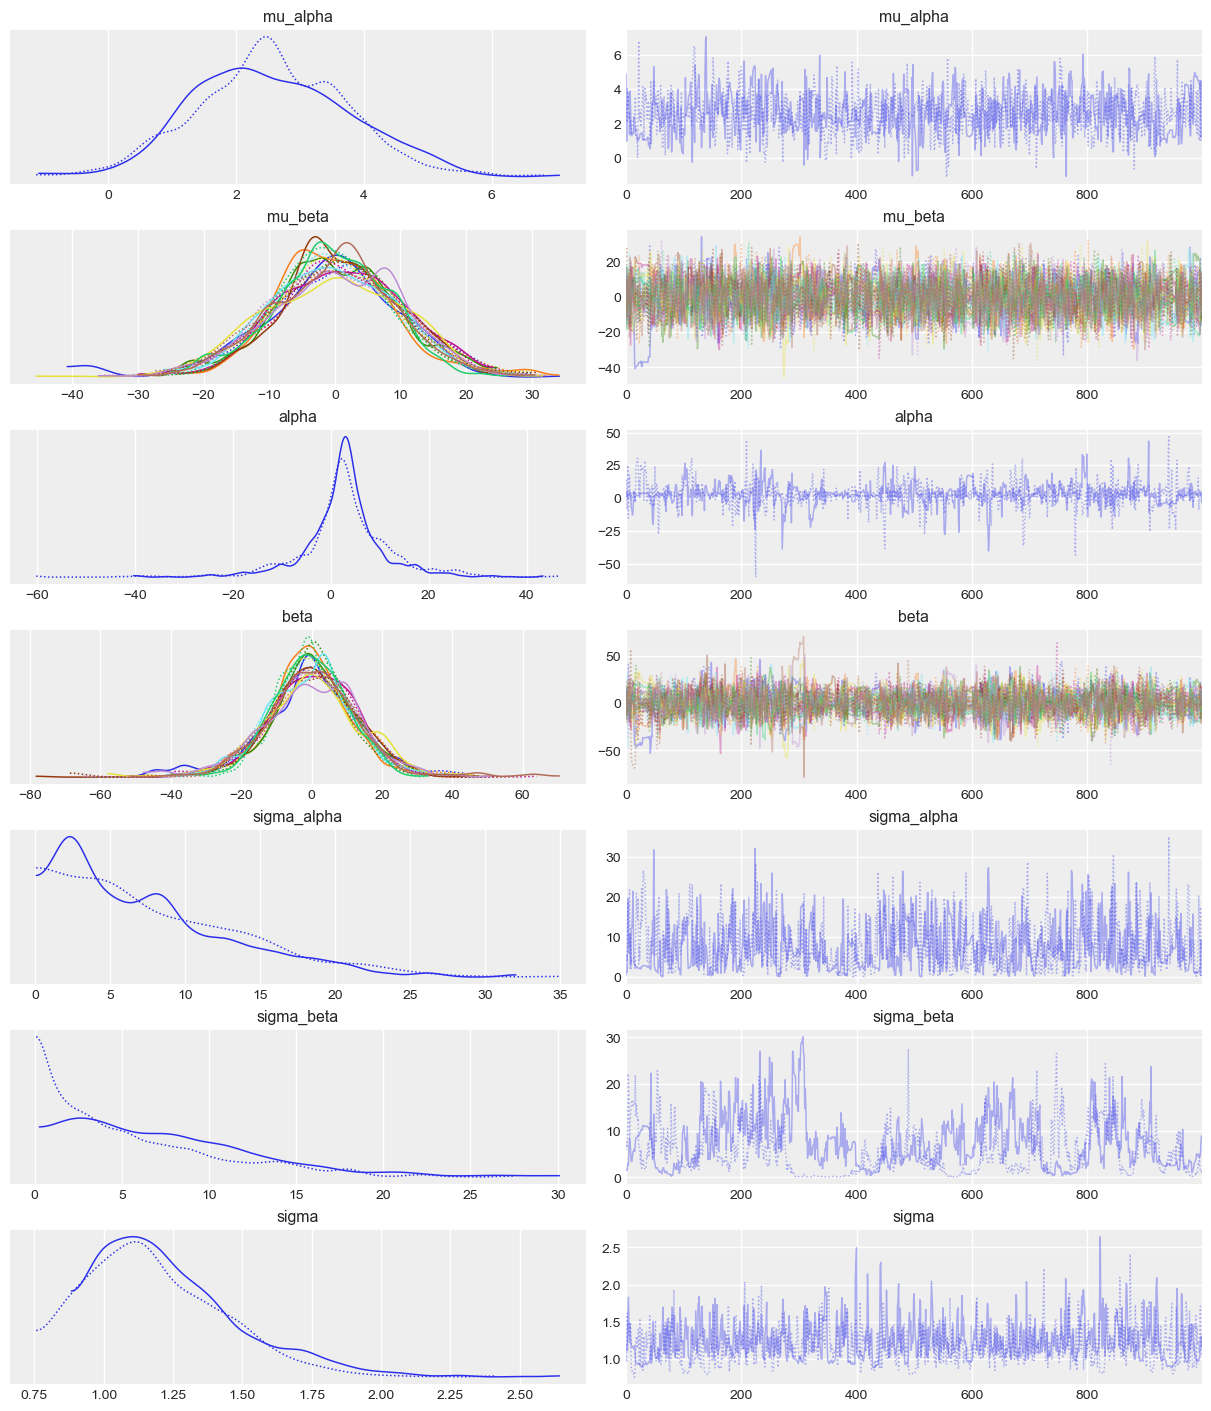

In [46]:
az.plot_trace(hier_traces[-1]);

## Prior sensitivity

In [47]:
hier_models_sens = []
hier_traces_sens = []
for i in range(hcl_idx-5, hcl_idx):
    with pm.Model() as hierarchical_model:
        # hyper-priors
        mu_alpha = pm.Uniform('mu_alpha', 0, 10)
        sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=10)
        mu_beta = pm.Uniform('mu_beta', 0, 10, shape=10)
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=10, shape=10)
        sigma = pm.HalfCauchy('sigma', beta=10)

        # priors
        alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha)
        beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=10)

        # likelihood
        mu = alpha + pm.math.dot(x[i], beta)
        y_pred = pm.StudentT('y_pred', nu=4, mu=mu, sd=sigma, observed=y[i])

        trace = pm.sample(1000, tune=1000, cores=2, chains=2, return_inferencedata=True)
        hier_models_sens.append(hier_model)
        hier_traces_sens.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 55 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.716467777135523, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 81 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.43242163217953017, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 51 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [48]:
trace_hcl_hier = hier_traces_sens[-1]
post_hier = az.convert_to_dataset(trace_hcl_hier)
mu_hcl_hier = post_hier.alpha[-1]
sigma_hier = post_hier.sigma.values[-1]

y_hcl_hier = np.zeros(len(mu_hcl_hier))

for i, current_mu in enumerate(mu_hcl_hier):
    y_hcl_hier[i] = np.random.normal(loc = mu_hcl_hier[i], scale = sigma_hier[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce. 
df = pd.DataFrame(y_hcl_hier)
df.describe(percentiles=[0.025, 0.975])

,0
count,1000.000000
mean,9.400178
std,34.798666
min,-88.961682
2.5%,-55.551243
50%,4.549579
97.5%,108.465041
max,156.590611


/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


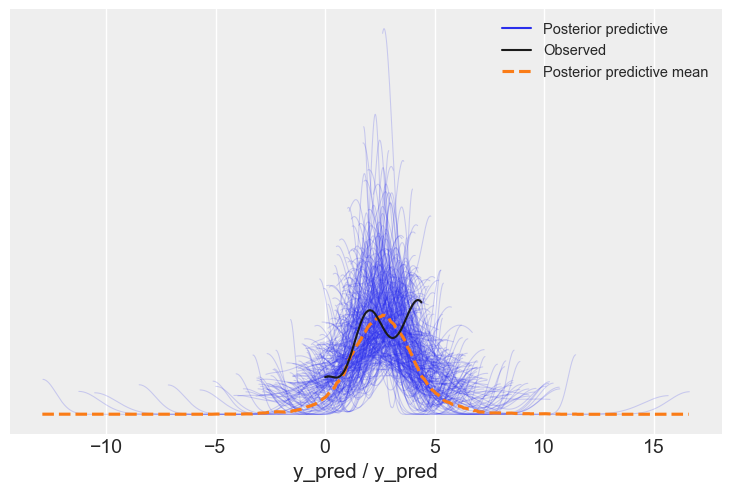

In [49]:
ppc = pm.sample_posterior_predictive(hier_traces[-1], samples=300, model=hier_models[-1])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=hier_models[-1]));

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


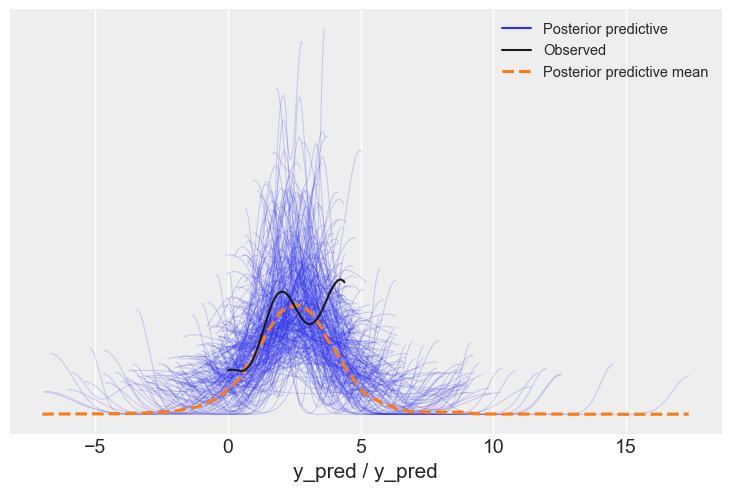

In [50]:
ppc = pm.sample_posterior_predictive(hier_traces_sens[-1], samples=300, model=hier_models_sens[-1])
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=hier_models_sens[-1]));

## WAIC comparison

In [51]:
for i in range(5):
  print(az.waic(hier_traces[i]))

Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -21.43     3.54
p_waic        1.87        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -23.58     2.50
p_waic        1.27        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -21.16     2.58
p_waic        1.38        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -23.00     2.83
p_waic        1.54        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -23.59     2.05
p_waic        1.43        -


/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [52]:
for i in range(5):
  print(az.waic(unpooled_traces[i]))

Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -21.57     3.44
p_waic        1.95        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -23.91     2.86
p_waic        1.76        -
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -21.25     2.88
p_waic        1.64        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -23.73     3.45
p_waic        2.57        -

There has been a warning during the calculation. Please check the results.
Computed from 2000 posterior samples and 13 observations log-likelihood matrix.

          Estimate       SE
elp

/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


When looking at the values summed up, we see that the hierarchical models is slightly better, with a score of 8.82 compared to the one of the unpooled model of 8.29.

# Comparing the models (hierarchical and pooled) on novelty prediction

In [53]:
print(az.waic(trace_novel))
print(az.waic(trace_h_novel))

Computed from 2000 posterior samples and 169 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -288.52    10.91
p_waic       11.28        -
Computed from 2000 posterior samples and 169 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -288.89    10.84
p_waic       11.57        -
